# AlexNet model on custom dataset
___

# Łódź University of Technology
## Faculty of Electrotechnics, Electronics, Information Technology and Automation Technology
## Institution of Medical Electronics

### Created by Dominik Dmowski
___

## Import dependencies

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

%matplotlib inline

In [2]:
# check if the TF is working on GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  1


___
## Load dataset structures (without loading images)

In [3]:
# set correct folder path
main_directory = r'Dataset-kidney-MRI'
test_directory = r'Dataset-kidney-MRI\Test'
train_directory = r'Dataset-kidney-MRI\Training'

# classes get by subdirectories in folders
kidney_classes = os.listdir(train_directory)
print("Dataset is devided into calsses (get from Training set): ", kidney_classes)
print("The dataset is divied into ", len(kidney_classes), " classes.")

Dataset is devided into calsses (get from Training set):  ['0', '1', '2']
The dataset is divied into  3  classes.


### Training

In [4]:
# load the training data

#train_directory = r'Dataset-kidney-MRI\Training'
#kidney_classes = os.listdir(train_directory)

training = []

for subdirectory in kidney_classes:
    # create path to subdirectories in training dataset
    sub_dir_path = os.path.join(train_directory, subdirectory)
    
    # loop over each item in subdirectory
    for file_path in glob.glob(os.path.join(sub_dir_path, '*.jpg')):
        training.append((str(subdirectory),str(file_path)))
        

        
        
print(len(training))
print(training[0])

21420
('0', 'Dataset-kidney-MRI\\Training\\0\\PK2_4_left_opp_020_0.jpg')


### Testing

In [5]:
# load the testing data

#test_directory = r'Dataset-kidney-MRI\Test'
#kidney_classes = os.listdir(test_directory)

testing = []

for subdirectory in kidney_classes:
    # create path to subdirectories in testing dataset
    sub_dir_path = os.path.join(test_directory, subdirectory)
    
    # loop over each item in subdirectory
    for file_path in glob.glob(os.path.join(sub_dir_path, '*.jpg')):
        testing.append((str(subdirectory),str(file_path)))
        

        
        
print(len(testing))
print(testing[0])

143
('0', 'Dataset-kidney-MRI\\Test\\0\\PK1_4_left_opp_021_0.jpg')


___

## Build dataframes

In [6]:
training_df = pd.DataFrame(data=training, columns=['class','image'])
testing_df = pd.DataFrame(data=testing, columns=['class','image'])

print(training_df.head())
print("Total number of samples in TRAINING set is equal to: ", len(training_df))
print("Total number of samples in TESTING set is equal to: ", len(testing_df))

  class                                              image
0     0  Dataset-kidney-MRI\Training\0\PK2_4_left_opp_0...
1     0  Dataset-kidney-MRI\Training\0\PK2_4_left_opp_0...
2     0  Dataset-kidney-MRI\Training\0\PK2_4_left_opp_0...
3     0  Dataset-kidney-MRI\Training\0\PK2_4_left_opp_0...
4     0  Dataset-kidney-MRI\Training\0\PK2_4_left_opp_0...
Total number of samples in TRAINING set is equal to:  21420
Total number of samples in TESTING set is equal to:  143


In [7]:
image_count = training_df['class'].value_counts()

print("Images per class in training set: ")
print(image_count)

Images per class in training set: 
class
1    9660
2    5964
0    5796
Name: count, dtype: int64


In [8]:
image_count = testing_df['class'].value_counts()

print("Images per class in testing set: ")
print(image_count)

Images per class in testing set: 
class
0    52
2    51
1    40
Name: count, dtype: int64


___

## Prepare and load images with corresponding labels
### Part with data preprocessing

In [9]:
# AlexNet as input takes images 227x227x3, so it is necessary to reshape the dataset

# set the image size
im_size = 227


#-----------FOR-TRAINING-DATA-----------
X_train = []
y_train = []

for subdirectory in kidney_classes:
    sub_dir_path = os.path.join(train_directory, subdirectory)
    for file_path in glob.glob(os.path.join(sub_dir_path, '*.jpg')):
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(im_size, im_size))
        X_train.append(image)
        y_train.append(int(subdirectory))
    
    
#-----------FOR-TESTING-DATA-----------
X_test = []
y_test = []

for subdirectory in kidney_classes:
    sub_dir_path = os.path.join(test_directory, subdirectory)
    for file_path in glob.glob(os.path.join(sub_dir_path, '*.jpg')):
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(im_size, im_size))
        X_test.append(image)
        y_test.append(int(subdirectory))

print("---------------TRAINING---------------")
print("Check if the whole TRAINING set has been loaded: ",
      len(y_train), "of LABELS and ",  len(X_train), " of IMAGES.")
print("Check the first training image shape: ", X_train[0].shape[0:])

print("\n\n---------------TESTING----------------")
print("Check if the whole TESTING set has been loaded: ",
      len(y_test), "of LABELS and ",  len(X_test), " of IMAGES.")
print("Check the first training image shape: ", X_test[0].shape[0:])

---------------TRAINING---------------
Check if the whole TRAINING set has been loaded:  21420 of LABELS and  21420  of IMAGES.
Check the first training image shape:  (227, 227, 3)


---------------TESTING----------------
Check if the whole TESTING set has been loaded:  143 of LABELS and  143  of IMAGES.
Check the first training image shape:  (227, 227, 3)


1


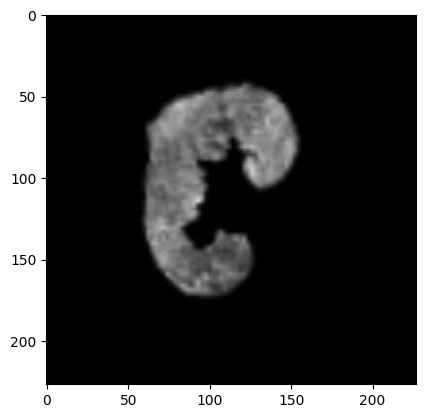

In [10]:
i = 11111

plt.imshow(X_train[i])
print(y_train[i])

In [11]:
# transform loaded images into numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

# divide by maximum possible pixel value to simplify computing
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

(21420, 227, 227, 3)
(143, 227, 227, 3)


In [12]:
# in case of calling classes by integers by default there is no need to encode the labels

X_train, y_train = shuffle(X_train, y_train, random_state=1)
X_test, y_test = shuffle(X_test, y_test, random_state=1)
print(X_train.shape)
print(len(y_train))
print(X_test.shape)
print(len(y_test))

(21420, 227, 227, 3)
21420
(143, 227, 227, 3)
143


In [15]:
# convert labels into one hots

y_train = tf.one_hot(y_train, 3)
y_test = tf.one_hot(y_test, 3)
print(y_train.shape)
print(y_test.shape)

(21420, 3)
(143, 3)


___
## Implement AlexNet

In [14]:
image_shape = (227,227,3)

# instantiate an empty model
np.random.seed(1000)

# initialize model
model = Sequential()

# 1st Conv layer
model.add(Conv2D(filters=96, input_shape=image_shape, kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# first kernel layer has 96 filters and the input image has shape 227 x 227 x 3
# kernel size is equal to 11 x 11, striding 4 x 4 and the activation function is relu

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides = (2,2), padding='valid'))

# 2nd Conv layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides = (2,2), padding='valid'))

# 3rd Conv layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Conv layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Conv layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides = (2,2), padding='valid'))

# Passing to Fully Connected layer, do the flatten
model.add(Flatten())

# 1st Fully conected layer with 4096 neurons
model.add(Dense(4096, input_shape=(227*227*3,)))
model.add(Activation('relu'))

# Drop out for preventing overfitting
model.add(Dropout(0.4))

# 2nd Fully conected layer
model.add(Dense(4096))
model.add(Activation('relu'))

# Drop out for preventing overfitting
model.add(Dropout(0.4))

# Output layer
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

# Compile the model
model.compile(loss = keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 23, 23, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                    

## Train the model

In [17]:
# set up early stop to terminate training after accuracy losses

from tensorflow.keras.callbacks import EarlyStopping

# initialize early stop object
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [ ]:
history = model.fit(x = X_train, y = y_train,
                   epochs = 150,
                   validation_data = (X_test, y_test),
                   callbacks=[early_stop],
                   shuffle=True)